In [3]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import statistics as stats

dtheta_inc = 0.018

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/256x384x128'
filename_prefix = directory+'/shearlayer_'

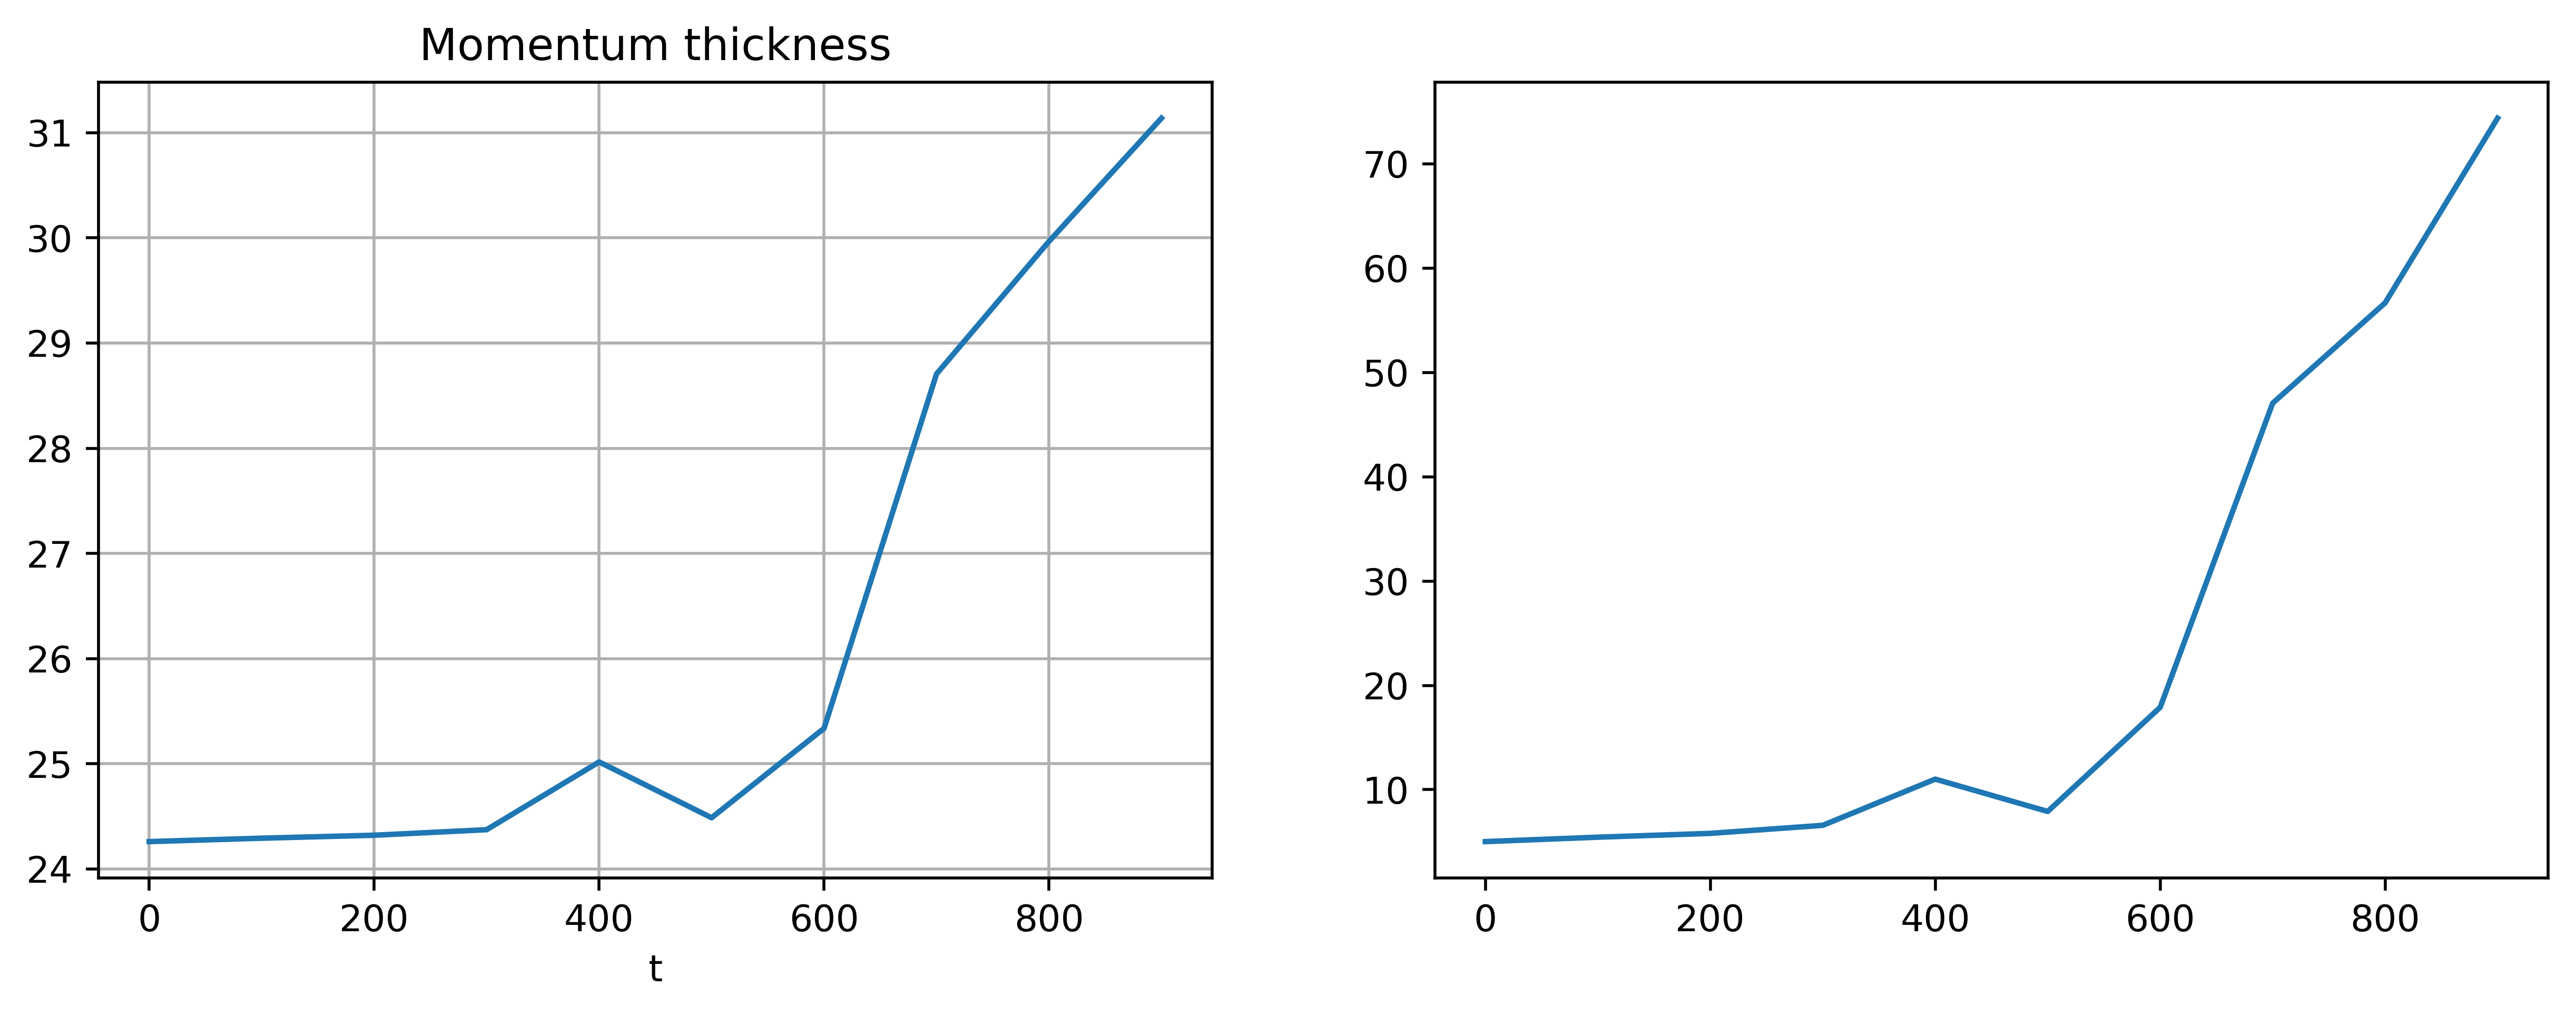

In [4]:
# Thicknesses

fname = filename_prefix+'growth.dat'
dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
n = np.size(dat)

nstats=3
dat = np.reshape(dat,[n/nstats,nstats])
time = dat[:,0]
dtheta = dat[:,1]
domega = dat[:,2]

# Plotting
fig, axarr = plt.subplots(1,2, figsize=(12,4), dpi=500) 
axarr[0].plot(time,dtheta); axarr[0].grid(True);
axarr[0].grid(True)
axarr[0].set_xlabel('t')
axarr[0].set_title('Momentum thickness')
axarr[1].plot(time,domega); axarr[0].grid(True)

dtheta growth: 3.94274702022 - 8.17758297802
domega growth: 21.2840202441 - 38.50712948
Fitting between times 700.0-900.0 (steps 7-9)
Approximate growth rate: 0.026039664344
Approximate normalized growth rate: 1.44664801911


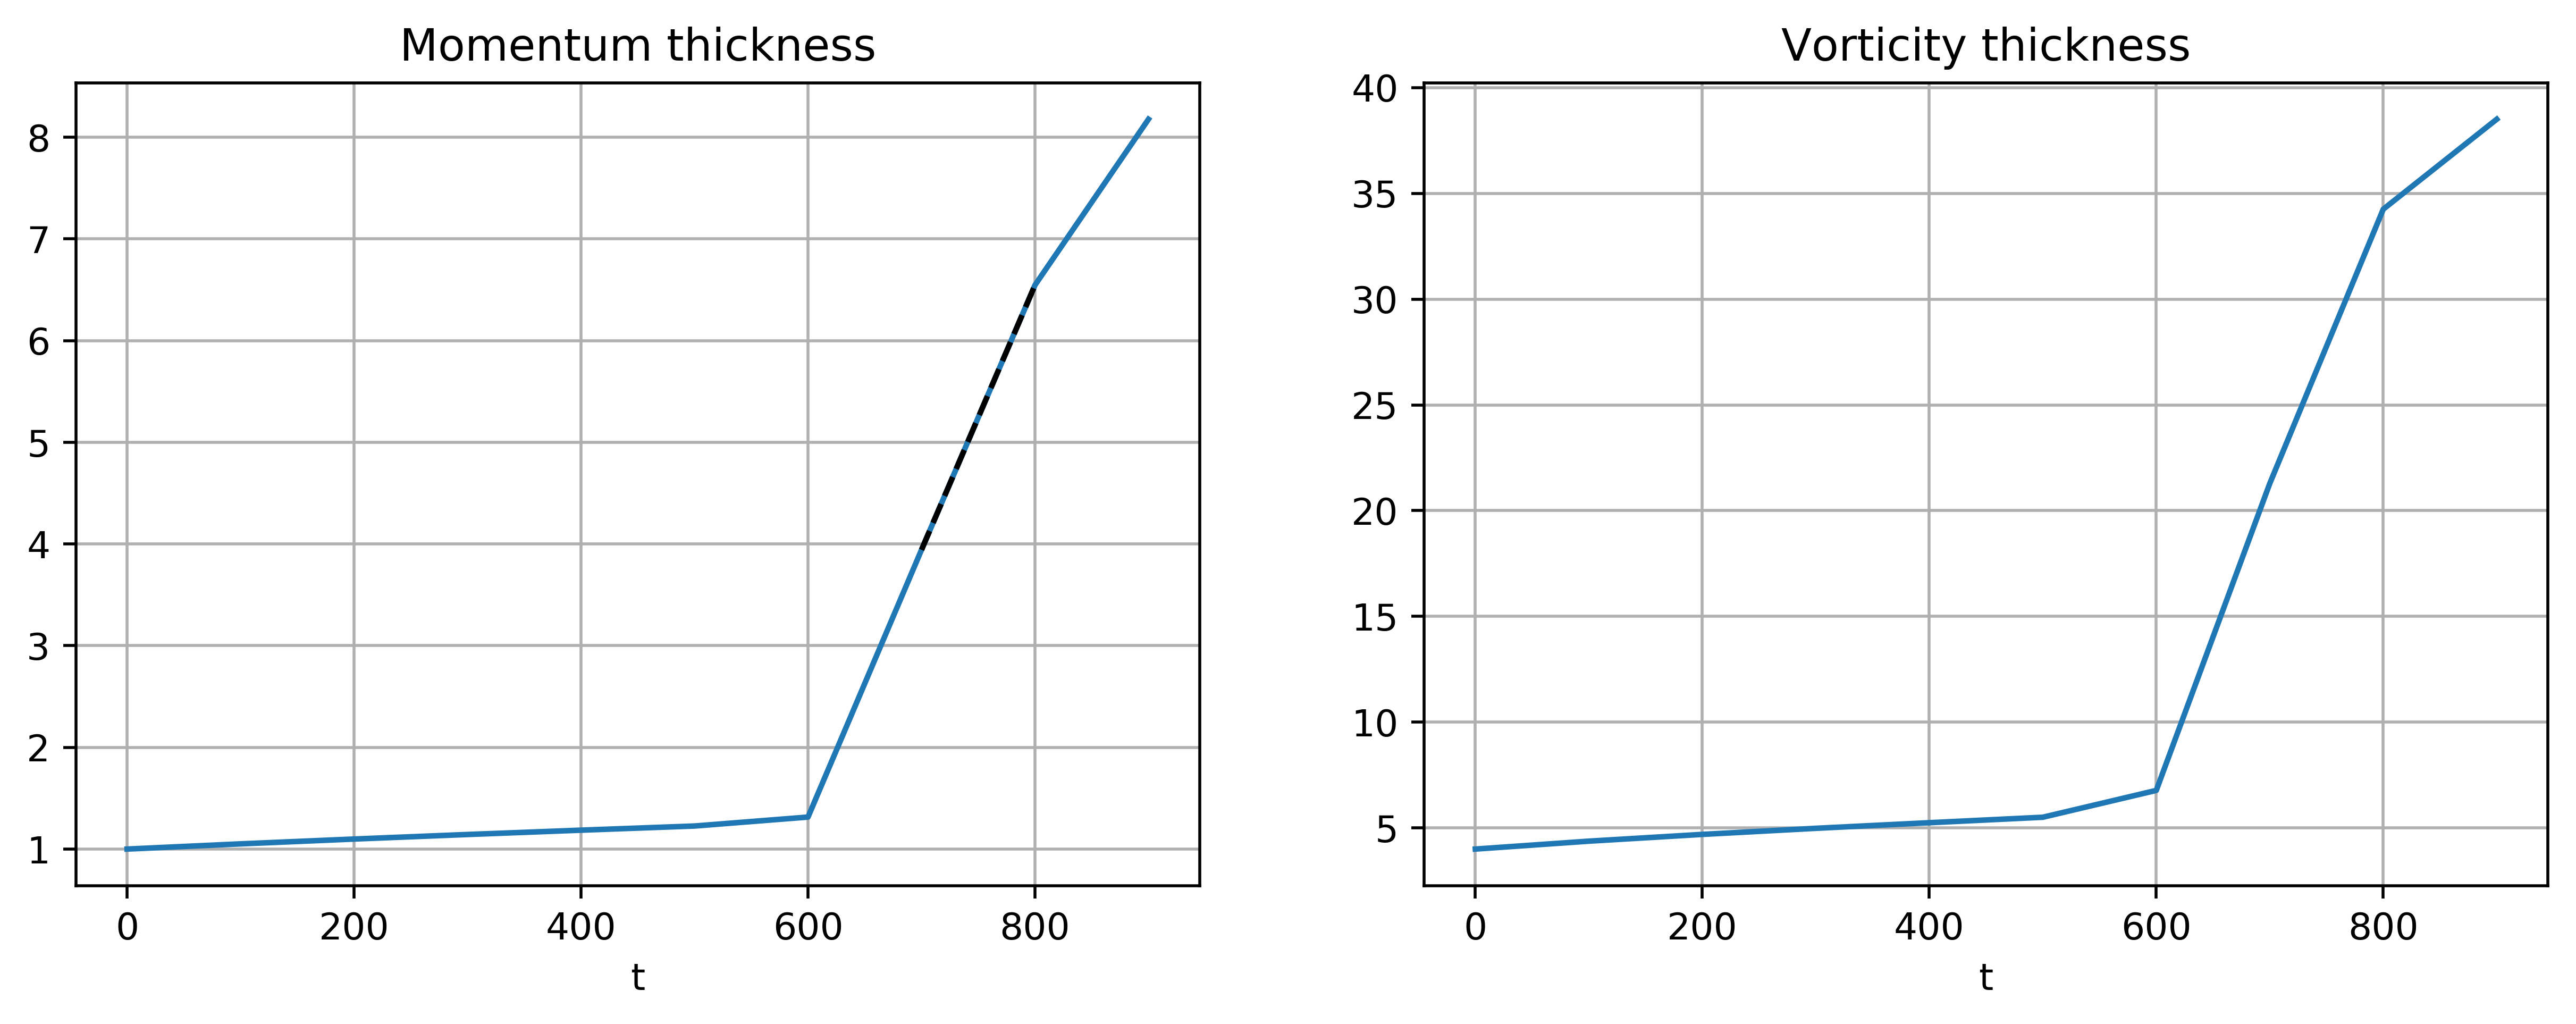

In [6]:
def which_tID(tvec,t):
    tmp = np.argmin(np.abs(tvec-t))
    return tmp

savefig = False

# Make linear fit
ts = which_tID(time,700)
te = which_tID(time,1000)
t_fit = time[ts:te]
dat_fit = dtheta[ts:te]
growth_rate,shift = np.polyfit(t_fit, dat_fit, 1) #linear fit
print("dtheta growth: {} - {}".format(dtheta[ts],dtheta[te]))
print("domega growth: {} - {}".format(domega[ts],domega[te]))

# Plotting
fig, axarr = plt.subplots(1,2, figsize=(12,4), dpi=500) 
axarr[0].plot(time,dtheta,'-')
axarr[0].plot(t_fit,t_fit*growth_rate+shift,'k--')
axarr[1].plot(time,domega)

# clean plots
axarr[0].grid(True)
axarr[0].set_xlabel('t')
axarr[0].set_title('Momentum thickness')
axarr[1].grid(True)
axarr[1].set_xlabel('t')
axarr[1].set_title('Vorticity thickness')
    
print("Fitting between times {}-{} (steps {}-{})".format(time[ts],time[te],ts,te))
print("Approximate growth rate: {}".format(growth_rate))
print("Approximate normalized growth rate: {}".format(growth_rate/dtheta_inc))

if savefig:
    savename = directory + "/../img/growth.png"
    plt.savefig(savename, dpi=500)
    print "Saved plot to ",savename

Text(0.5,1,'Domain Integrated TKE')

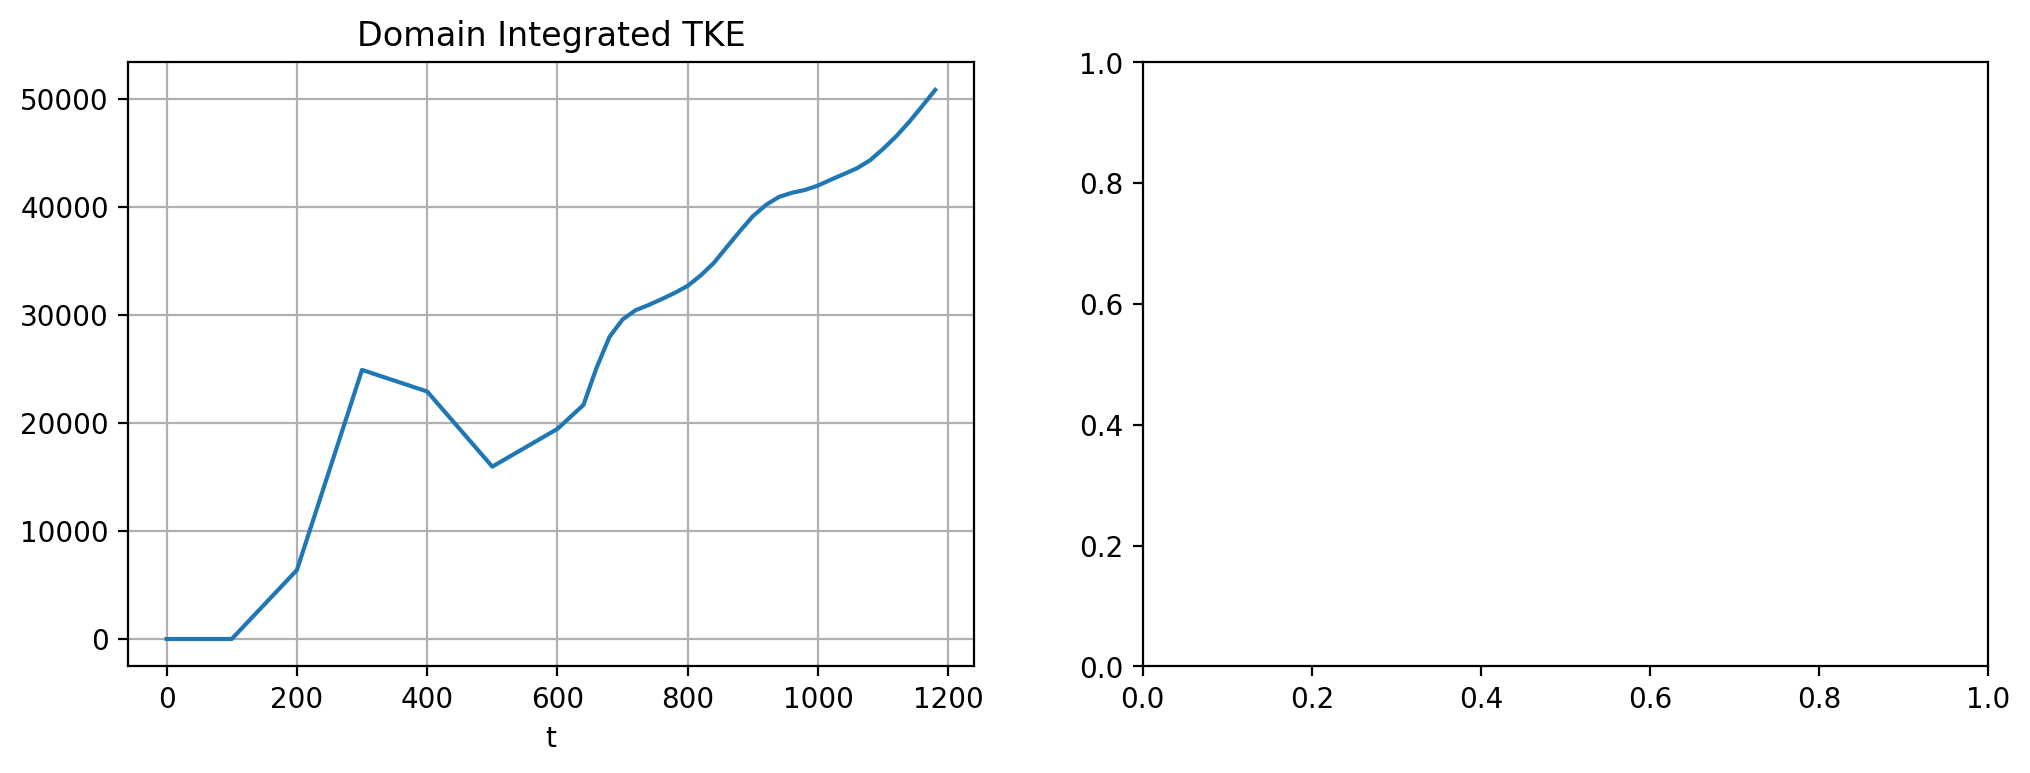

In [14]:
# TKE
fname = filename_prefix+'TKE_growth.dat'
dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
n = np.size(dat)

nstats=2
dat = np.reshape(dat,[n/nstats,nstats])
time = dat[:,0]
tke = dat[:,1]

# Plotting
fig, axarr = plt.subplots(1,2, figsize=(12,4), dpi=200) 
axarr[0].plot(time,tke); 
axarr[0].grid(True)
axarr[0].set_xlabel('t')
axarr[0].set_title('Domain Integrated TKE')